In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [83]:
df_logins = pd.read_json('logins.json', convert_dates = True)

In [84]:
len(df_logins.login_time)

93142

In [85]:
df_logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


After reading the file and running its description, we see that the series contains 93142 values, but only 92265 are unique. The number of non-unique entries is quite large, and we will assume that these are the results of inadequate quality of data rather than the fact that different users made their logins at the same moment of time with one-second precision.

In [86]:
df_logins.drop_duplicates(inplace = True)
df_logins.reset_index(drop =True, inplace =True)
len(df_logins.index)

92265

In [87]:
df_logins.describe()

,login_time
count,92265
unique,92265
top,1970-03-19 13:50:20
freq,1
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


Let's aggregate the login counts based on the 15-minutes time interval. To do this, we introduce the column 'visits' and assign value of 1 to all rows in it. After that, we make 'login_time' our index column and resample taking the sum with respect to visits.  

In [88]:
df_logins.login_time = pd.to_datetime(df_logins.login_time,  errors='coerce')
df_logins['visits'] = 1
df_logins.set_index('login_time', inplace = True)

In [89]:
df_logins.head(10)

,visits
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1
1970-01-01 20:21:41,1
1970-01-01 20:12:16,1
1970-01-01 20:35:47,1
1970-01-01 20:35:38,1


In [90]:
df_logins_new = df_logins.resample('15min', closed = 'left').sum()

In [91]:
len(df_logins_new.index)

9788

The new dataframe contains 9788 entries in total and 407 NaN's corresponding to the absence of logins; we replace the latter entries by zeroes.

In [92]:
df_logins_new.isnull().sum()

visits    407
dtype: int64

In [93]:
df_logins_new.fillna(0, inplace = True)

1) Let's aggregate the data over months and look at the distribution. We see that the largest number of logins occurred in March, while the smallest in April. This is because April is represented only by 13 days.

In [94]:
df10  = df_logins_new.resample('M', closed = 'left').sum()

writer1 = pd.ExcelWriter('table1.xlsx')
df10.to_excel(writer1)
writer1.save()

df10

,visits
login_time,
1970-01-31,20308.0
1970-02-28,23855.0
1970-03-31,34000.0
1970-04-30,14102.0


2) We then look at the distributions over days for January, February and March. The plots below clearly demonstrate the presence of periods approximately equal to 7 days. The graphs also suggest that the number of daily logins increases towards the end of the week and reaches maximum during weekend.

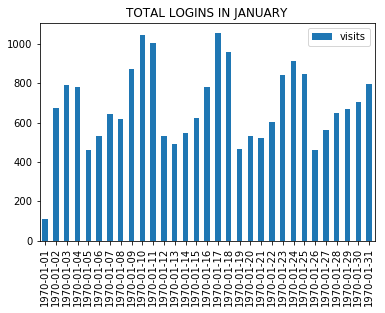

In [95]:
df9 = pd.DataFrame(df_logins_new['1970-01'].resample('D', closed = 'left').sum())

df9.set_index(df9.index.date, inplace = True)

fig1a = df9.plot(title = 'TOTAL LOGINS IN JANUARY', kind = 'bar').get_figure()
    
plt.show()

fig1a.savefig('Jan_logins.pdf')

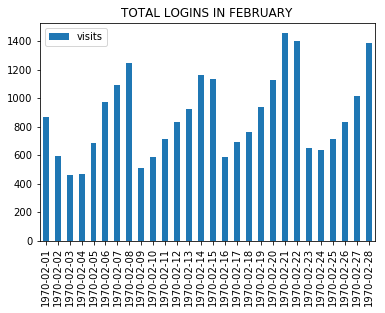

In [96]:
df8 = pd.DataFrame(df_logins_new['1970-02'].resample('D', closed = 'left').sum())

df8.set_index(df8.index.date, inplace = True)
    
fig2a = df8.plot(title = 'TOTAL LOGINS IN FEBRUARY', kind = 'bar').get_figure()

plt.show()

fig2a.savefig('Feb_logins.pdf')

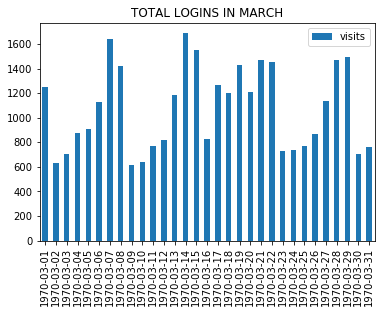

In [97]:
df7 = pd.DataFrame(df_logins_new['1970-03'].resample('D', closed = 'left').sum())

df7.set_index(df7.index.date, inplace = True)
         
fig3a = df7.plot(title = 'TOTAL LOGINS IN MARCH', kind = 'bar').get_figure()

plt.show()

fig3a.savefig('Mar_logins.pdf')

To ascertain the latter statement, we plot the weekly distribution of logins for month March, and then compute the average number of logins during weekends and during weekdays for the whole dataset. The first graph below shows that the total number of logins per each full week does not change much. At the same time, the table presented next shows that the average number of logins during weekends is almost 1.5 larger than during weekdays.

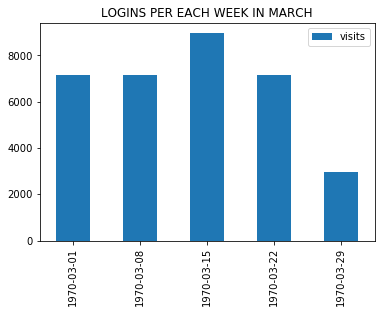

In [98]:
df6 = pd.DataFrame(df_logins_new['1970-03'].resample('W', closed = 'left', label = 'left').sum())

df6.set_index(df6.index.date, inplace = True)
     
fig4 = df6.plot(title = 'LOGINS PER EACH WEEK IN MARCH', kind = 'bar').get_figure()
    
plt.show()

fig4.savefig('Weekly_logins.pdf')

In [99]:
df5 = df_logins_new.reset_index()

df5['dayofweek'] = df5.login_time.dt.dayofweek

def func1(dfr):
    if dfr['dayofweek'] in [5, 6]:
        return 1.0
    else:
        return 0.0

df5['weekend'] = df5.apply(func1, axis =1)
df5.drop('dayofweek', inplace = True, axis =1)

In [100]:
df4 = pd.DataFrame(df5.groupby('weekend')['visits'].mean())

writer2 = pd.ExcelWriter('table2.xlsx')
df4.to_excel(writer2)
writer2.save()

df4

,visits
weekend,
0.0,7.984366
1.0,12.885069


In [101]:
del(df4, df5, df6, df7, df8, df9, df10)

3) Finally, we look at the hourly distribution of the number of logins. Let's first take two arbitrary business days, do the hourly aggregation and plot the results. We see that the number of logins increases after business hours, and has a peak in the middle of the day, presumably during the lunch time.

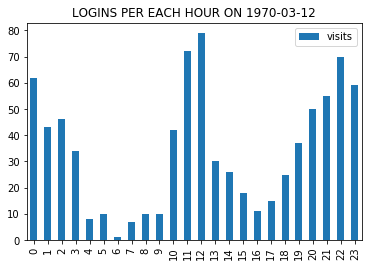

In [102]:
df11= pd.DataFrame(df_logins_new['1970-03-12'].resample('H', closed = 'left', label = 'left').sum())

df11.set_index(df11.index.hour, inplace = True)

fig5a = df11.plot(title = 'LOGINS PER EACH HOUR ON 1970-03-12', kind = 'bar').get_figure()
  


plt.show()

fig5a.savefig('Hourly_logins1.pdf')

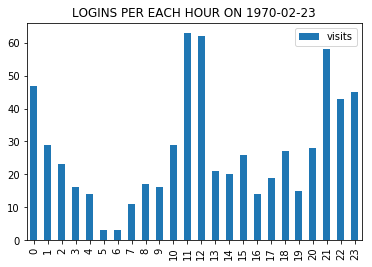

In [103]:
df12 = pd.DataFrame(df_logins_new['1970-02-23'].resample('H', closed = 'left', label = 'left').sum())

df12.set_index(df12.index.hour, inplace = True)
     
fig5b = df12.plot(title = 'LOGINS PER EACH HOUR ON 1970-02-23', kind = 'bar').get_figure()
    
plt.show()

fig5b.savefig('Hourly_logins2.pdf')

From the other side, it is interesting to look at the typical hourly distribution of logins during a weekend day, say Saturday. '1970-01-17' is Saturday. We see that the number of logins is high during the late night/early morning hours, but the smallest during the late morning hours. During the day/evening hours the number of logins is relatively evenly distributed. This picture suggests that many users prefer to spend night before computers and take a sleep closer to morning hours on weekends. 

In [104]:
print('The day of week of 1970-01-17 is:', df_logins_new.loc['1970-01-17'].index.dayofweek[0])

The day of week of 1970-01-17 is: 5


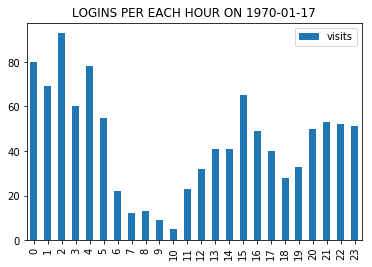

In [105]:
df13 = pd.DataFrame(df_logins_new['1970-01-17'].resample('H', closed = 'left', label = 'left').sum())

df13.set_index(df13.index.hour, inplace = True)
     
fig5c = df13.plot(title = 'LOGINS PER EACH HOUR ON 1970-01-17', kind = 'bar').get_figure()
    
plt.show()

fig5c.savefig('Hourly_logins3.pdf')

In [106]:
del(df11,df12,df13)